In [1]:
import requests
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pprint import pprint
from statistics import mean
from requests.auth import HTTPBasicAuth
from client import client_id, client_secret

In [2]:
## Authorization token to access spotify api (Required for all endpoints)
token_url = "https://accounts.spotify.com/api/token"
headers = {'content-type': 'application/x-www-form-urlencoded'}

token_params = {"grant_type" : "client_credentials"}

token_json = requests.post(token_url, params = token_params, headers = headers, auth = (client_id, client_secret)).json()

# Temporary token to access spotify endpoints
token = token_json['access_token']

In [3]:
token_headers = {'authorization': f"Bearer {token}"}

# Read CSV for US top 50 songs
US_top50_df = pd.read_csv("Top Country CSV/US_top_50.csv")

# Counts the amount of artist in the CSV (Should count 50)
artist_count = 0

# List to store genres and amount of time each genre is read
genres = []
genre_count = []

# Search endpoint for artists
search_artist_url = "https://api.spotify.com/v1/artists/"

# Loops through each artists ID in CSV file
for artist_id in US_top50_df["Artist ID"]:
    artist_url = search_artist_url + artist_id
    
    # Get artist json format
    artist_json = requests.get(artist_url, headers = token_headers).json()
    
    try:
        # Genres for each artists, result should be a list of genres
        genres_list = artist_json["genres"]
        
        # Loops through the genre list to store genre into a list and count the amount of time it appears
        for genre in genres_list:
            
            # If genre not in list, then append and creates a new count for that specific genre in genre_count list
            if genre not in genres:
                genres.append(genre)
                genre_count.append(1)
            
            # If genre is already in list, then indent count by 1 for that genre
            else:
                genre_count[genres.index(genre)] += 1
                
        artist_count += 1
    
    # List artist ID if it cannot be requested from spotify endpoint
    except (KeyError, IndexError):
        print(f"Artist ID not found | {artist_id}")
        
# Zip together both lists to put in numerical descending order
genre_zip = zip(genres, genre_count)
sorted_genre_zip = sorted(genre_zip, key = lambda count : count[1], reverse = True)

genre = list(zip(*sorted_genre_zip))[0]
genre_count = list(zip(*sorted_genre_zip))[1]

In [4]:
# Create DataFrame with genre, genre counts, and percentage of artist that lie within the genre
genre_popularity_df = pd.DataFrame({"Genres" : genre, "Genre Counts" : genre_count})
genre_popularity_df["Genre Popularity Percentage"] = (genre_popularity_df["Genre Counts"]/artist_count) * 100
genre_popularity_df.head()

,Genres,Genre Counts,Genre Popularity Percentage
0,pop,28,56.0
1,rap,25,50.0
2,trap music,18,36.0
3,dance pop,12,24.0
4,pop rap,11,22.0


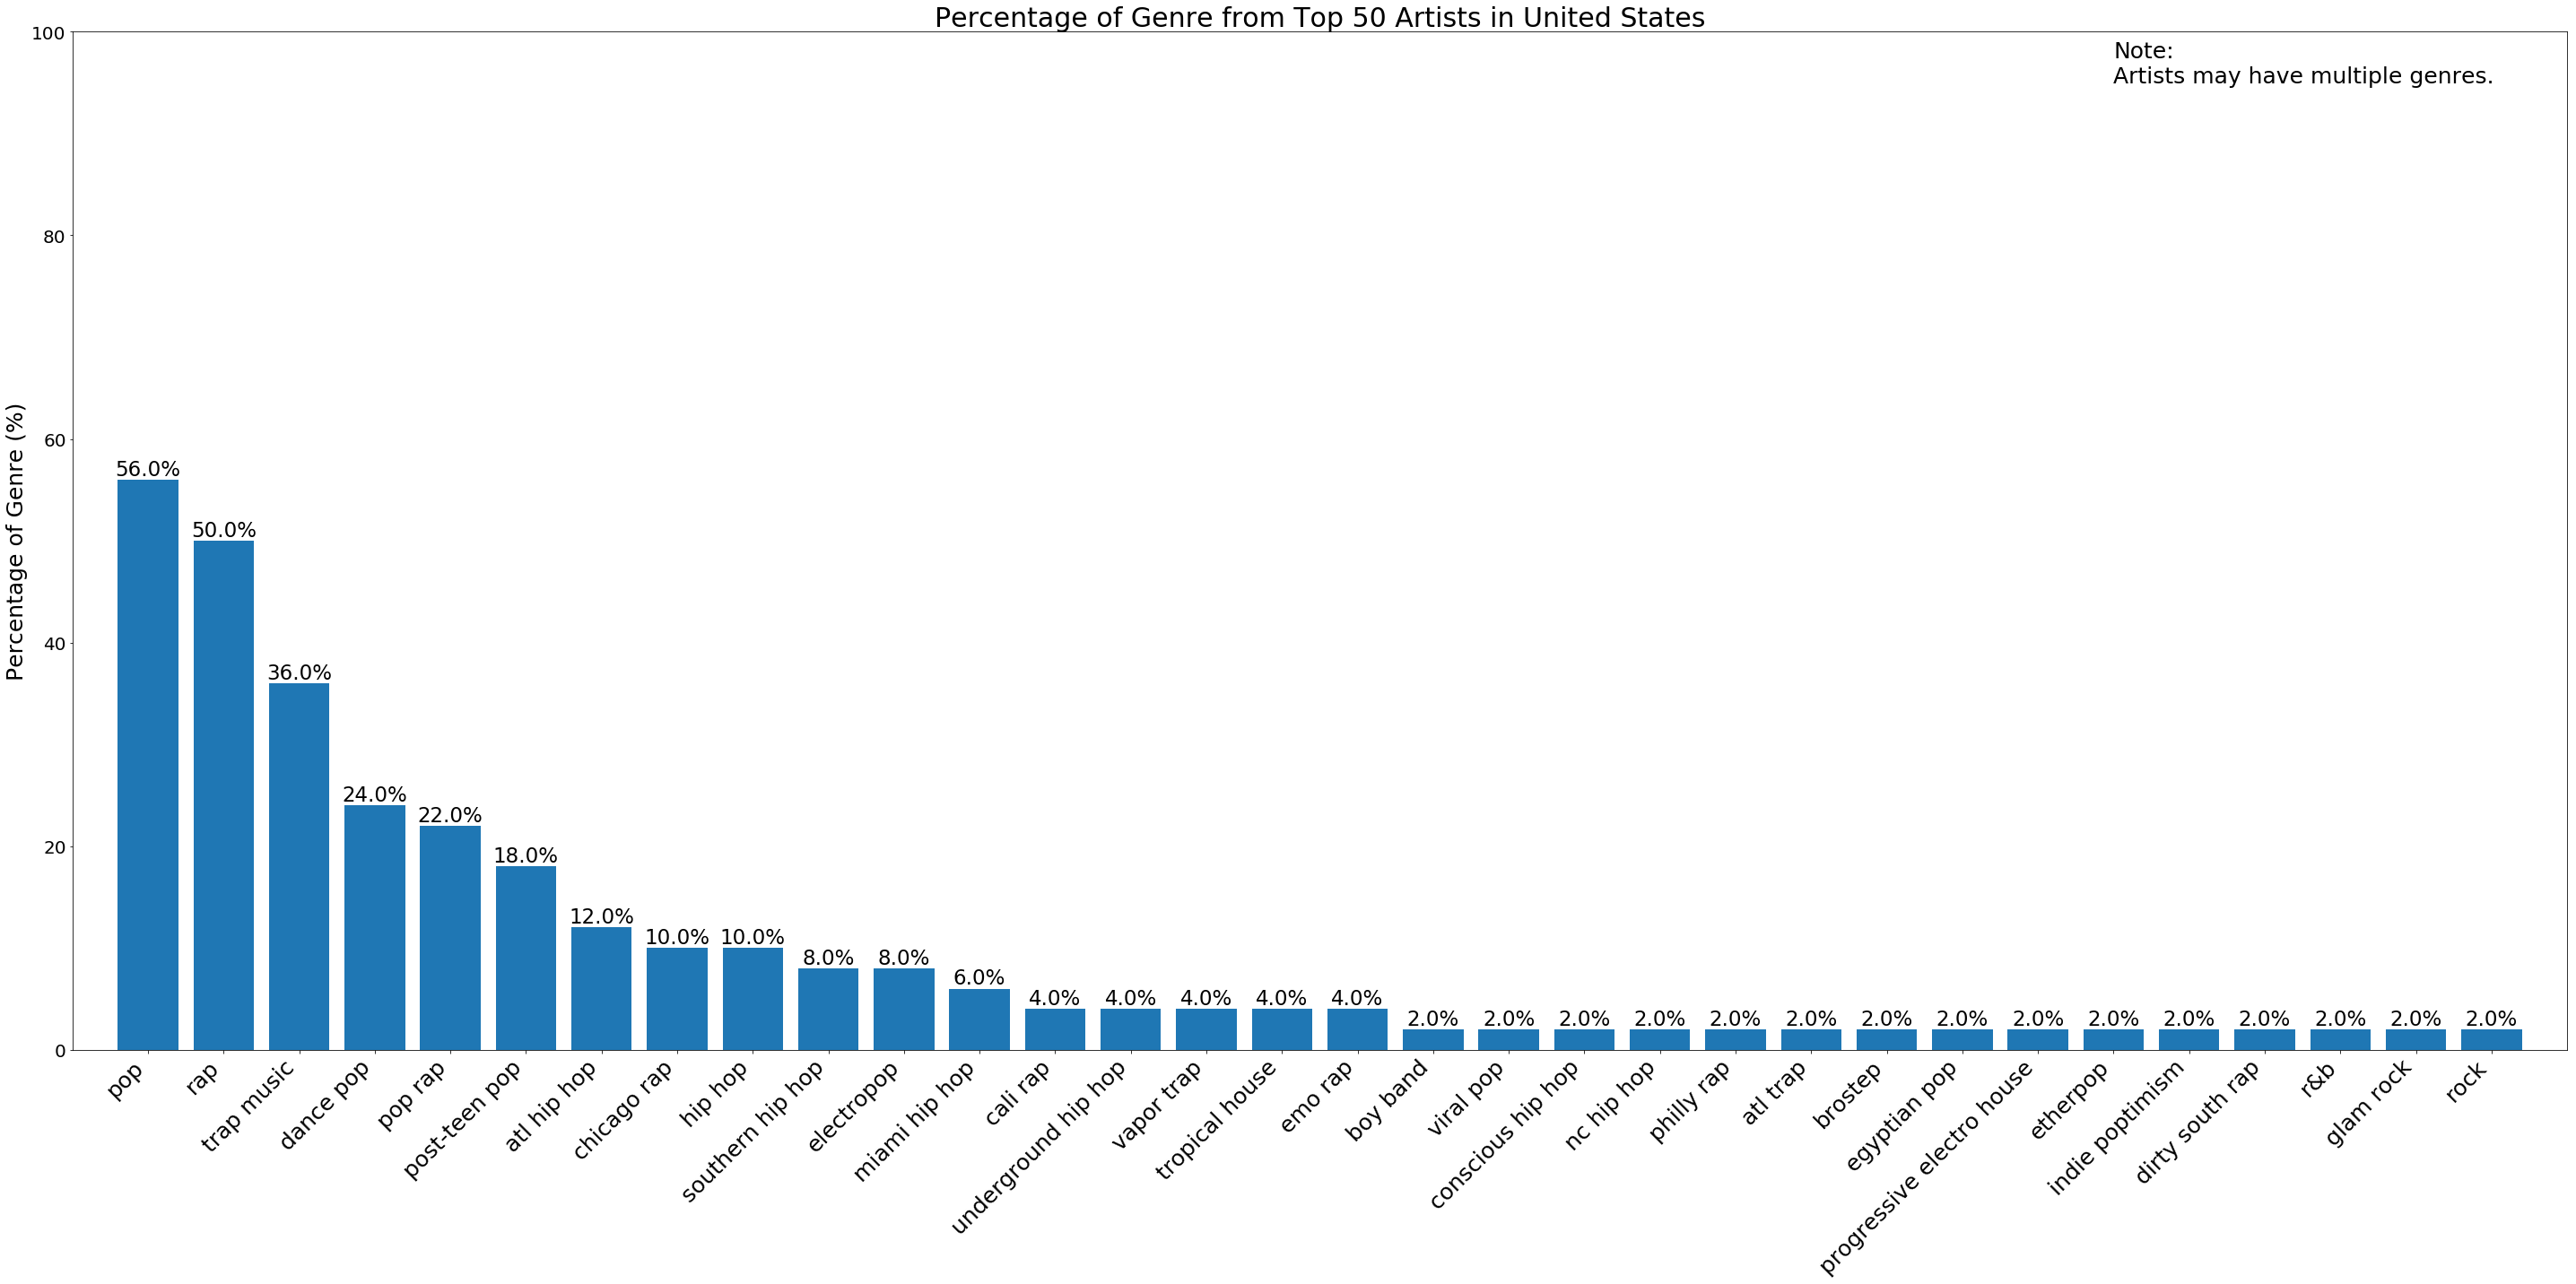

In [5]:
# Create figure size
fig, ax = plt.subplots(figsize = (40,20))

# Number of genres
x_axis = np.arange(len(genre))

# Percentage of genres
y_axis = genre_popularity_df["Genre Popularity Percentage"]

# Create bar graph showing percentage of genres in US
ax.bar(x_axis, y_axis)

# Label x and y axis
plt.xticks(x_axis, genre_popularity_df["Genres"], Fontsize = 25, rotation = 45, ha = "right")
plt.yticks(Fontsize = 20)

plt.xlim(min(x_axis) - 1, max(x_axis) + 1)
plt.ylim(0, 100)

plt.ylabel("Percentage of Genre (%)", Fontsize = 25)
plt.title("Percentage of Genre from Top 50 Artists in United States", Fontsize = 30)
plt.text(max(x_axis) - 5, 95, "Note:\nArtists may have multiple genres.", Fontsize = 25)

# Dimension of each bar box
rects = ax.patches

# Loops through each box to grab dimensions
for rect in rects:
    
    # Width of Box
    box_width = rect.get_width()
    
    # Height of Box
    height = rect.get_height()
    
    # Center of Box
    center = rect.get_x() + box_width / 2
    
    # Text is above boxes if height greater than 0
    if height > 0:
        ax.text(center, height, f'{round(height,2)}%', Fontsize = 23, ha = 'center', va = 'bottom')
        
    # Text is below boxes if height is less than 0
    else:
         ax.text(center, height, f'{round(height,2)}%', Fontsize = 23, ha = 'center', va = 'top')

# Better fit for graph to prevent axis cutoffs
plt.tight_layout()

# Save figure
plt.savefig("Images/Percentage_of_ALL_Genre_from_Top50_Artists_in_US.png")
            
plt.show()

In [6]:
artist_count = 0

# Count amount of pop, trap, and rap artists and store their danceability score
pop_count = 0
pop_danceability = []

trap_count = 0
trap_danceability = []

rap_count = 0
rap_danceability = []

# Loops though range of of artists in CSV
for i in range(len(US_top50_df["Artist ID"])):
    
    # Grab artist ID within row
    artist_url = search_artist_url + US_top50_df["Artist ID"][i]
    
    artist_json = requests.get(artist_url, headers = token_headers).json()
    
    try:
        genre_list = artist_json["genres"]
        
        # If pop, trap, and rap listed as genre for artist, then genre count +1 and append danceability score in same row in CSV
        if "pop" in genre_list:
            pop_count += 1
            pop_danceability.append(US_top50_df["Danceability"][i])
            
        if "trap music" in genre_list:
            trap_count += 1
            trap_danceability.append(US_top50_df["Danceability"][i])
            
        if "rap" in genre_list:
            rap_count += 1
            rap_danceability.append(US_top50_df["Danceability"][i])
                
        artist_count += 1
    
    # Print Artist ID that could not be requested from spotify endpoint
    except (KeyError, IndexError):
        print(f"Artist ID not found | {artist_id}")

In [7]:
# T-Test on mean of pop danceability and mean of rap danceability to find significant variance
stats.ttest_ind(pop_danceability, rap_danceability, equal_var=False)

Ttest_indResult(statistic=-1.08755782990692, pvalue=0.2819078485308637)

The high p-value indicates that there is no significance between pop and rap danceability scores.

In [8]:
# T-Test on mean of pop danceability and mean of trap danceability to find significant variance
stats.ttest_ind(pop_danceability, trap_danceability, equal_var=False)

Ttest_indResult(statistic=-1.041304020350646, pvalue=0.303893141048772)

The high p-value indicates that there is no significance between pop and trap danceability scores.

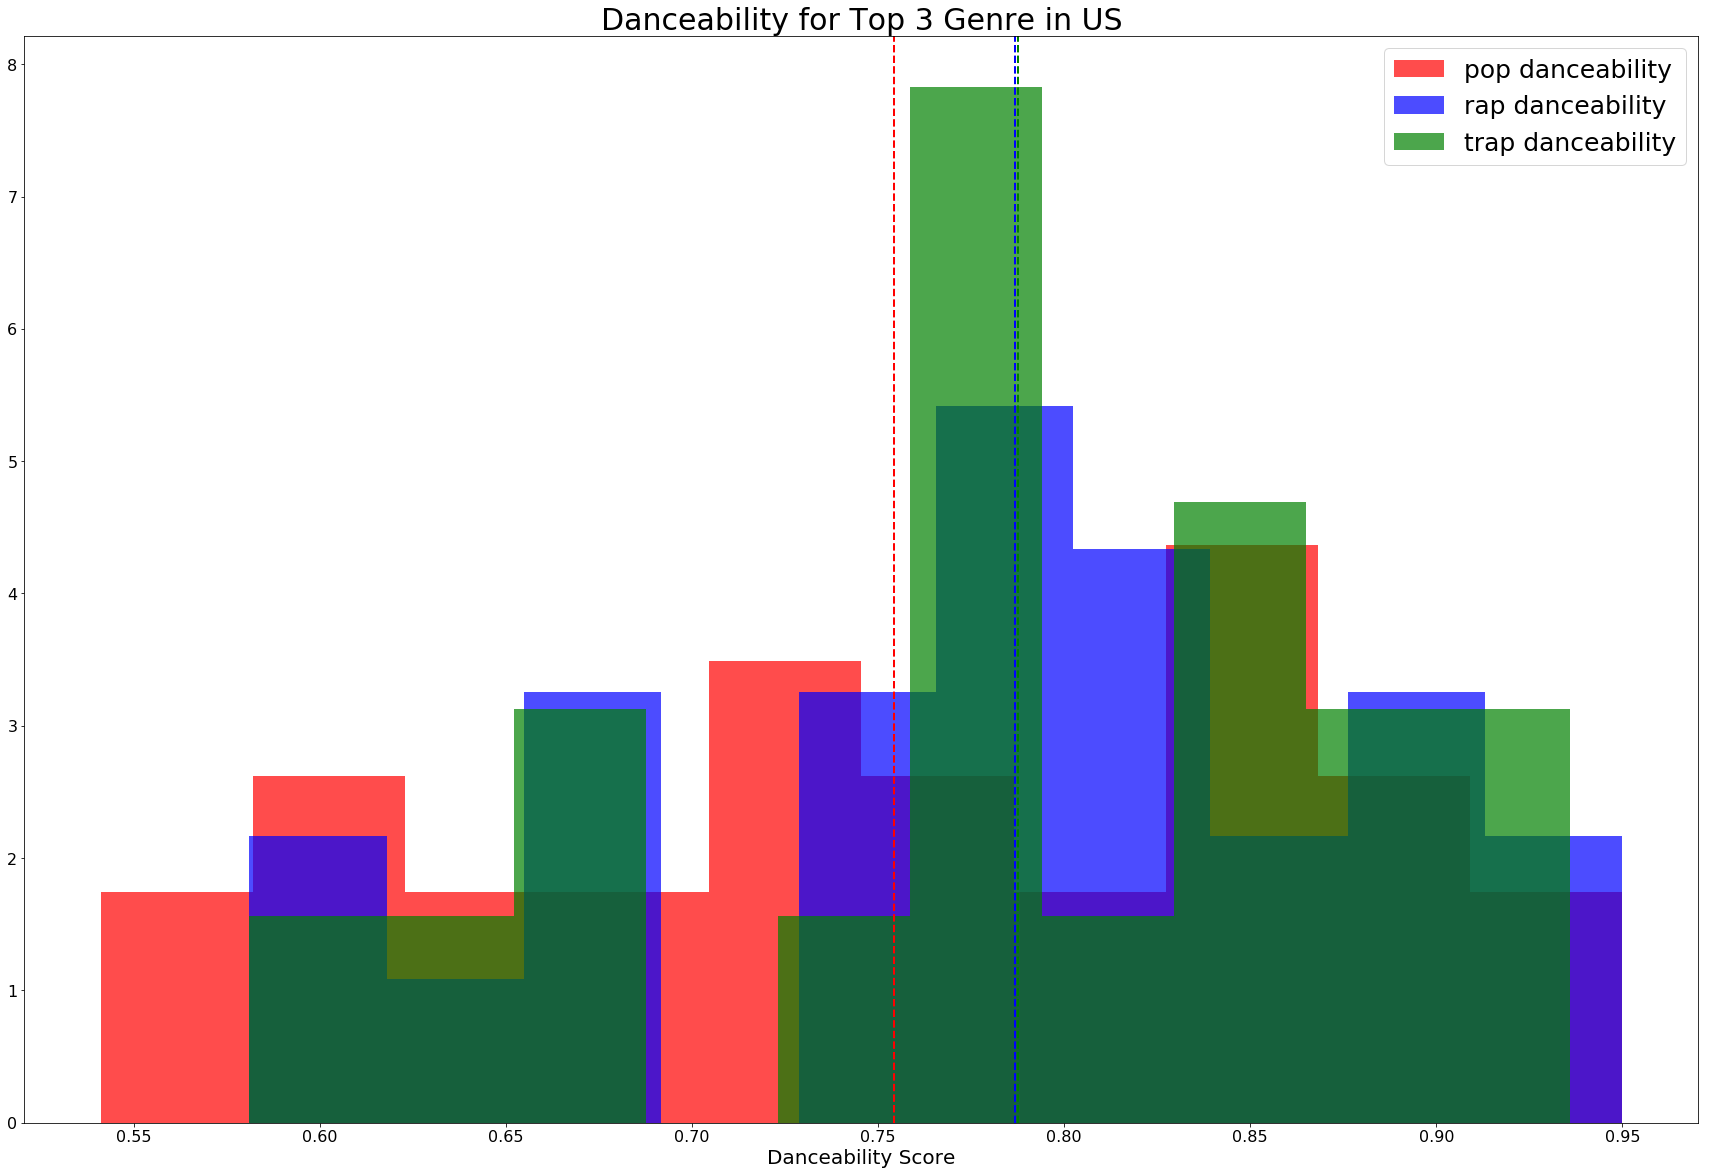

In [9]:
# Calculate mean from list of danceability scores according to their genre
pop_danceability_mean = mean(pop_danceability)
rap_danceability_mean = mean(rap_danceability)
trap_danceability_mean = mean(trap_danceability)

# Create figure and size
fig, ax = plt.subplots(figsize = (30,20))

# Create histogram for top 3 genres in US by danceability
ax.hist(pop_danceability, density = True, alpha = 0.7, color = 'r', label = "pop danceability")
ax.hist(rap_danceability, density = True, alpha = 0.7, color = 'b', label = "rap danceability")
ax.hist(trap_danceability, density = True, alpha = 0.7, color = 'g', label = "trap danceability")

# Dotted line to observe mean of the three genre danceability
ax.axvline(pop_danceability_mean, color='r', linestyle='dashed', linewidth = 2)
ax.axvline(rap_danceability_mean, color='b', linestyle='dashed', linewidth = 2)
ax.axvline(trap_danceability_mean, color = 'g', linestyle='dashed', linewidth = 2)

# Labels and fontsizes
plt.xlabel("Danceability Score", Fontsize = 20)
plt.xticks(Fontsize = 16)
plt.yticks(Fontsize = 16)
plt.title("Danceability for Top 3 Genre in US", Fontsize = 30)

# Create legend
plt.legend(loc = "best", prop={'size': 25})

# Save figure
plt.savefig("Images/Danceability_Histogram_for_Top_3_Genre_in_US.png")

plt.show()

In [10]:
# Create DataFrame with only top 3 genres and their danceability scores
pop_danceability_df = pd.DataFrame({"Danceability" : pop_danceability})
pop_danceability_df.insert(0, "Genre", "pop")

rap_danceability_df = pd.DataFrame({"Danceability" : rap_danceability})
rap_danceability_df.insert(0, "Genre", "rap")

trap_danceability_df = pd.DataFrame({"Danceability" : trap_danceability})
trap_danceability_df.insert(0, "Genre", "trap")

# Combine all three DataFrames by appending to first
genre_danceability_df = pop_danceability_df.append([rap_danceability_df, trap_danceability_df])

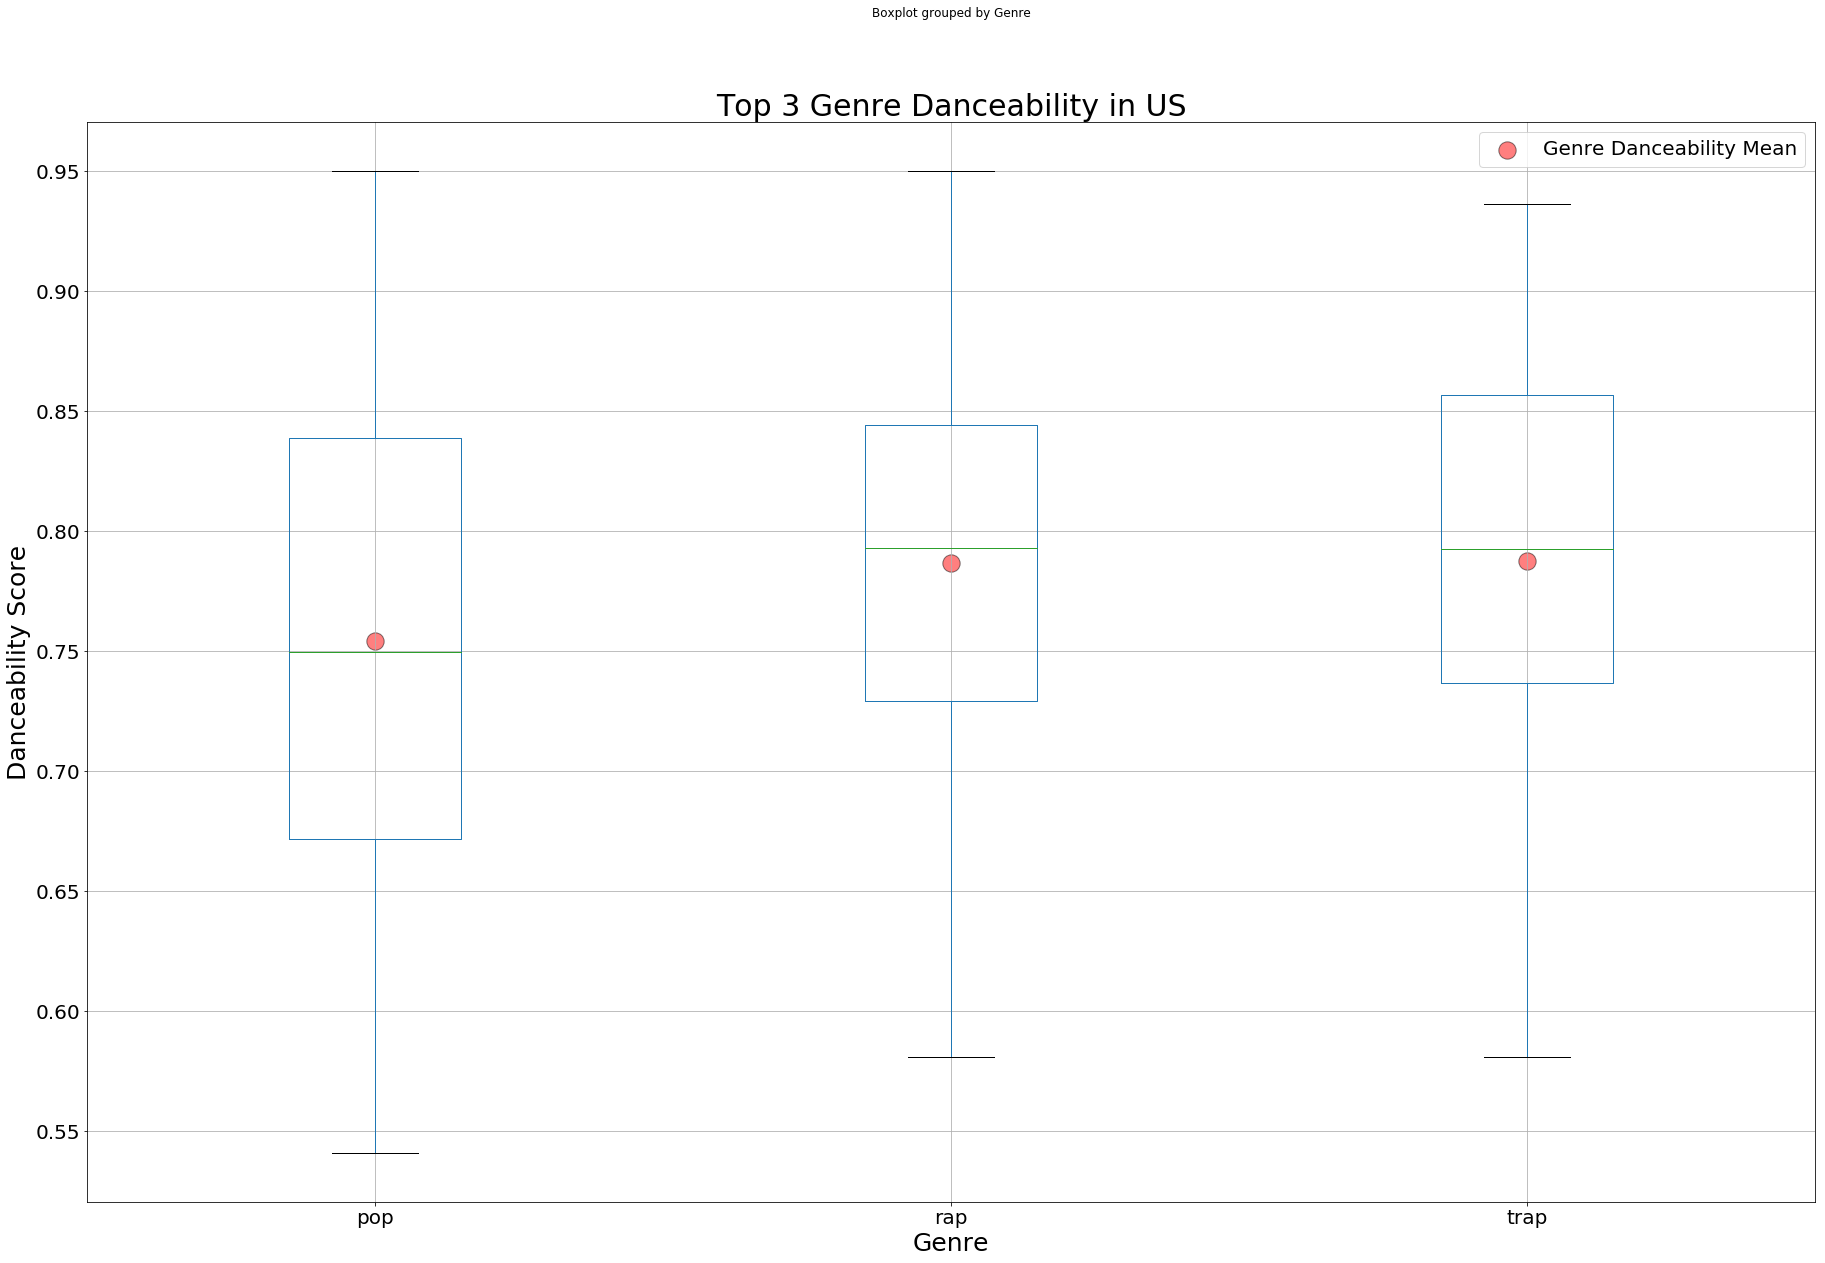

In [11]:
# Boxplot for top 3 genre danceability in US
genre_danceability_df.boxplot("Danceability", by = "Genre", figsize = (30,20))

# Get axis for current plot
ax = plt.gca()

# X-Axis from 1 to 3
x_axis = np.arange(ax.get_xlim()[0] + ax.get_xlim()[0], ax.get_xlim()[1], 1)

# Plot mean for each genre popularity
plt.scatter(x_axis, [pop_danceability_mean, rap_danceability_mean, trap_danceability_mean], color = 'r', alpha = 0.5, edgecolor = 'k', s = 300, label = "Genre Danceability Mean")

# Add labels and adjust fontsizes
plt.title("Top 3 Genre Danceability in US", Fontsize = 30)
plt.xticks(Fontsize = 20)
plt.yticks(Fontsize = 20)
plt.xlabel("Genre", Fontsize = 25)
plt.ylabel("Danceability Score", Fontsize = 25)

# Add legend
plt.legend(loc = "best", prop={'size': 20})

# Save figure
plt.savefig("Images/Top_3_Genre_Danceability_in_US_Boxplot.png")

plt.show()

In [12]:
# ANOVA test on all three genre popularity mean
stats.f_oneway(pop_danceability, rap_danceability, trap_danceability)

F_onewayResult(statistic=0.8015744589613095, pvalue=0.45281503719545635)

The high p-value indicates that there is no significance among the three genre in the US. Thus we refute the hypothesis that if pop is the most popular genre in the US, then pop has a higher danceability score.